<a href="https://colab.research.google.com/github/Kim-yk/Section_2_Project/blob/main/Untitled25_(2)_(2)_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# https://www.kaggle.com/rikdifos/credit-card-approval-prediction
# https://www.kaggle.com/vinaykhujat/credit-card-approval-prediction

In [1]:
# pandas-profiling을 위한 설치
! pip install -U pandas-profiling

# category_encoders을 위한 설치
! pip install category_encoders
! pip install -U scikit-learn
! pip install mlrose
! pip install scikit-learn==0.22.1


! pip install shap
! pip install pdpbox
! pip install eli5

     |████████████████████████████████| 256kB 12.0MB/s 
     |████████████████████████████████| 61kB 6.3MB/s 
     |████████████████████████████████| 10.1MB 26.8MB/s 
     |████████████████████████████████| 1.1MB 50.4MB/s 
     |████████████████████████████████| 3.1MB 45.1MB/s 
     |████████████████████████████████| 81kB 9.1MB/s 
     |████████████████████████████████| 112kB 47.6MB/s 
     |████████████████████████████████| 645kB 39.9MB/s 
     |████████████████████████████████| 296kB 62.7MB/s 
  Created wheel for htmlmin: filename=htmlmin-0.1.12-cp37-none-any.whl size=27099 sha256=9304868c75b125459462c8f5f3dc4fcad66c9c7ef760ec80a5b4ff0e33fad1b1
  Stored in directory: /root/.cache/pip/wheels/43/07/ac/7c5a9d708d65247ac1f94066cf1db075540b85716c30255459
  Created wheel for phik: filename=phik-0.11.2-cp37-none-any.whl size=1107437 sha256=7954474af3d515df29fa45758731cc54628265457672a6f927747186d7cae040
  Stored in directory: /root/.cache/pip/wheels/c0/a3/b0/f27b1cfe32ea131a3715169132ff6d85

     |████████████████████████████████| 112kB 14.4MB/s 


### 1) 데이터 선정 이유 및 문제 정의 ###
- 시장 경제에서 어떤 분야의 사업에서든 소비자에 대한 관리는 중요하다고 생각 됩니다. 따라서 소비자에 관한 데이터를 가지고 그들에 대한 정보를 유추하는 능력을 기르기 위해 이 데이터를 골랐습니다.

- "분류" 문제로 접근할 것 입니다.

In [2]:
# 필요 라이브러리 불러오기

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
app = pd.read_csv('/content/application_record.csv')
credit = pd.read_csv('/content/credit_record.csv')

### 2)  데이터를 이용한 가설 및 평가지표, 베이스라인 선택###

고객의 정보를 가지고 분석하여 미래 다른 고객의 신뢰도를 판단 할 수 있을 것이다.
따라서 예측 해야 할 Target은 현재 모은 데이터에서 고객의 "STATUS" 이다.


- BaseLine
- 분류 문제이므로 타겟 변수에서 빈번히 나타나는 범주를 기준모델로 설정 하였다.
- 평가 지표
- 분류 문제이므로 정밀도(Precision),재현율(Recall),정확도(Accuracy)등을 평가지표로 사용할 것이다.

0    0.883658
1    0.116342
Name: STATUS, dtype: float64
BaseLine Accuracy: 0.8836577144721105


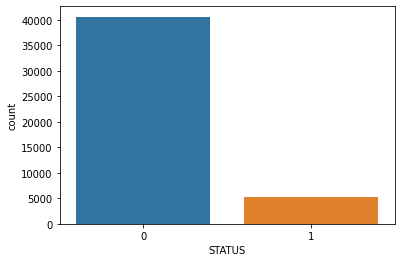

In [4]:
credit['STATUS'].replace(['C', 'X'],0, inplace=True)
credit['STATUS'].replace(['2','3','4','5'],1, inplace=True)

credit['STATUS'] = credit['STATUS'].astype('int')

# 'STATUS' => 0 = Good Client, 1 = Bad Client
target = 'STATUS'

y_BL_train = credit[target]
y_BL_train.value_counts(normalize = True)

# 타겟간의 값 차이가 너무 많이 나는 것을 알 수 있다. 왜 그런지 알아보자

credit
# 같은 ID 가 MONTHS_BALANCE로 인해 여러개 중복되는 것을 알 수 있다.

# 중복 없애기
credit_no_dup = credit.groupby('ID').agg(max).reset_index()
credit_no_dup

y_BL_train_1 = credit_no_dup[target]
print(y_BL_train_1.value_counts(normalize = True))
sns.countplot(x=y_BL_train_1);

# 이전보다 "STATUS"의 value 차이가 줄어든 것을 볼 수 있지만 여전히 데이터가 불균형인 것을 알 수 있다.

major = y_BL_train_1.mode()[0]
y_pred = [major] * len(y_BL_train_1)

# 베이스 라인 정확도(평가)
from sklearn.metrics import accuracy_score
print("BaseLine Accuracy:" , accuracy_score(y_BL_train_1,y_pred))

In [ ]:
# Target의 데이터가 불균형이기 때문에 베이스 라인 의 정확도는 그다지 유용하지 않다. 

###3)  EDA 및 데이터 전처리###

In [5]:
# 데이터가 target가 분리 되어 있으므로 데이터 먼저 합치기
df = pd.merge(app, credit_no_dup, on = 'ID', how = 'inner')
df.head()

ID CODE_GENDER FLAG_OWN_CAR  ... CNT_FAM_MEMBERS  MONTHS_BALANCE  STATUS
0  5008804           M            Y  ...             2.0               0       1
1  5008805           M            Y  ...             2.0               0       1
2  5008806           M            Y  ...             2.0               0       0
3  5008808           F            N  ...             1.0               0       0
4  5008809           F            N  ...             1.0             -22       0

[5 rows x 20 columns]

In [6]:
# 데이터 프로파일링으로 데이터 훑어보기
import pandas_profiling
from pandas_profiling import ProfileReport

df_pr = df.profile_report()
df_pr

Summarize dataset:   0%|          | 0/33 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

- 결측치 처리 하기 및 필요없는 컬럼 드랍

In [7]:
# 결측치 확인하기

df.isnull().sum()
# OCCUPATION_TYPE 컬럼에만 위치해 있는 것을 알 수 있다.

ID                         0
CODE_GENDER                0
FLAG_OWN_CAR               0
FLAG_OWN_REALTY            0
CNT_CHILDREN               0
AMT_INCOME_TOTAL           0
NAME_INCOME_TYPE           0
NAME_EDUCATION_TYPE        0
NAME_FAMILY_STATUS         0
NAME_HOUSING_TYPE          0
DAYS_BIRTH                 0
DAYS_EMPLOYED              0
FLAG_MOBIL                 0
FLAG_WORK_PHONE            0
FLAG_PHONE                 0
FLAG_EMAIL                 0
OCCUPATION_TYPE        11214
CNT_FAM_MEMBERS            0
MONTHS_BALANCE             0
STATUS                     0
dtype: int64

In [8]:
df['OCCUPATION_TYPE'].unique()
# 결측치도 많고 cardinality도 크기 떄문에 이 특성은 drop 시키자

array([nan, 'Security staff', 'Sales staff', 'Accountants', 'Laborers',
       'Managers', 'Drivers', 'Core staff', 'High skill tech staff',
       'Cleaning staff', 'Private service staff', 'Cooking staff',
       'Low-skill Laborers', 'Medicine staff', 'Secretaries',
       'Waiters/barmen staff', 'HR staff', 'Realty agents', 'IT staff'],
      dtype=object)

In [9]:
# 결측치 및 불필요 컬럼 제거
def del_col(df):
  df.drop('OCCUPATION_TYPE', axis = 1, inplace = True)
  # 'MONTHS_BALANCE'에 'STATUS' 가 나누어 지기 때문에 비슷한 내용을 담은 Feature를 2개 둘 필요가 없다.
  df.drop('MONTHS_BALANCE', axis = 1, inplace = True)
  df.drop('ID', axis = 1, inplace = True)

  return df

In [10]:
del_col(df)

CODE_GENDER FLAG_OWN_CAR  ... CNT_FAM_MEMBERS  STATUS
0               M            Y  ...             2.0       1
1               M            Y  ...             2.0       1
2               M            Y  ...             2.0       0
3               F            N  ...             1.0       0
4               F            N  ...             1.0       0
...           ...          ...  ...             ...     ...
36100           F            Y  ...             3.0       0
36101           F            Y  ...             3.0       0
36102           F            N  ...             2.0       0
36103           F            N  ...             2.0       0
36104           F            N  ...             2.0       0

[36105 rows x 17 columns]

In [11]:
data = df.copy()

- Feature Engineering

In [12]:
print(data[data['DAYS_EMPLOYED'] > 0]['DAYS_EMPLOYED'].nunique()) # 이상치로 생각하자
# 이것 한 개 빼고 모두 employed 된 상태이다.

print(data[data['DAYS_EMPLOYED']>0]['DAYS_EMPLOYED'].unique())
# unemployed 를 아조 높은 값으로 지정해 놓았다.

1
[365243.]


In [13]:
data.head()

CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  ...  FLAG_EMAIL  CNT_FAM_MEMBERS STATUS
0           M            Y               Y  ...         0.0              2.0      1
1           M            Y               Y  ...         0.0              2.0      1
2           M            Y               Y  ...         0.0              2.0      0
3           F            N               Y  ...         1.0              1.0      0
4           F            N               Y  ...         1.0              1.0      0

[5 rows x 17 columns]

In [14]:
def feature_engineering(data):
  # 보기 쉽게 나이로 전환
  data['AGE'] = np.trunc(data['DAYS_BIRTH']/-365)
  data.drop('DAYS_BIRTH',axis = 1 , inplace = True)

  # 'DAYS_EMPLOYED' => 'YEARS_EMPLOYED'
  data['DAYS_EMPLOYED'].replace(365243, 0, inplace=True)
  data['DAYS_EMPLOYED'] = abs(np.trunc(data['DAYS_EMPLOYED']/-365))
  data.rename(columns={'DAYS_EMPLOYED':'YEARS_EMPLOYED'}, inplace = True)

  #	'FLAG_MOBIL'은 value 가 1밖에 없다.(data['FLAG_MOBIL'].value_counts() = 1) 드랍!!
  data.drop('FLAG_MOBIL',axis = 1, inplace =  True)

  # 'FLAG_WORK_PHONE',	'FLAG_PHONE',	'FLAG_EMAIL' (개인 연락 수단('FLAG_MOBIL')을 재외한 다른 연락 수단)
  data['Contact info Num without MOBIL'] = data['FLAG_WORK_PHONE'] + data['FLAG_PHONE'] + data['FLAG_EMAIL'] 
  data.drop('FLAG_WORK_PHONE',axis = 1, inplace =  True)
  data.drop('FLAG_PHONE',axis = 1, inplace =  True)
  data.drop('FLAG_EMAIL',axis = 1, inplace =  True)
  return data

In [15]:
feature_engineering(data)

CODE_GENDER FLAG_OWN_CAR  ...   AGE  Contact info Num without MOBIL
0               M            Y  ...  32.0                             1.0
1               M            Y  ...  32.0                             1.0
2               M            Y  ...  58.0                             0.0
3               F            N  ...  52.0                             2.0
4               F            N  ...  52.0                             2.0
...           ...          ...  ...   ...                             ...
36100           F            Y  ...  38.0                             0.0
36101           F            Y  ...  38.0                             0.0
36102           F            N  ...  48.0                             0.0
36103           F            N  ...  48.0                             0.0
36104           F            N  ...  34.0                             0.0

[36105 rows x 14 columns]

- Outlier 확인 및 제거하기 (Numeric Feature)

In [16]:
data.dtypes != 'obeject'

CODE_GENDER                       True
FLAG_OWN_CAR                      True
FLAG_OWN_REALTY                   True
CNT_CHILDREN                      True
AMT_INCOME_TOTAL                  True
NAME_INCOME_TYPE                  True
NAME_EDUCATION_TYPE               True
NAME_FAMILY_STATUS                True
NAME_HOUSING_TYPE                 True
YEARS_EMPLOYED                    True
CNT_FAM_MEMBERS                   True
STATUS                            True
AGE                               True
Contact info Num without MOBIL    True
dtype: bool

In [17]:
numeric_cols_data = []
for col in data.columns:
  if data[col].dtypes != 'object':
    numeric_cols_data.append(col) 

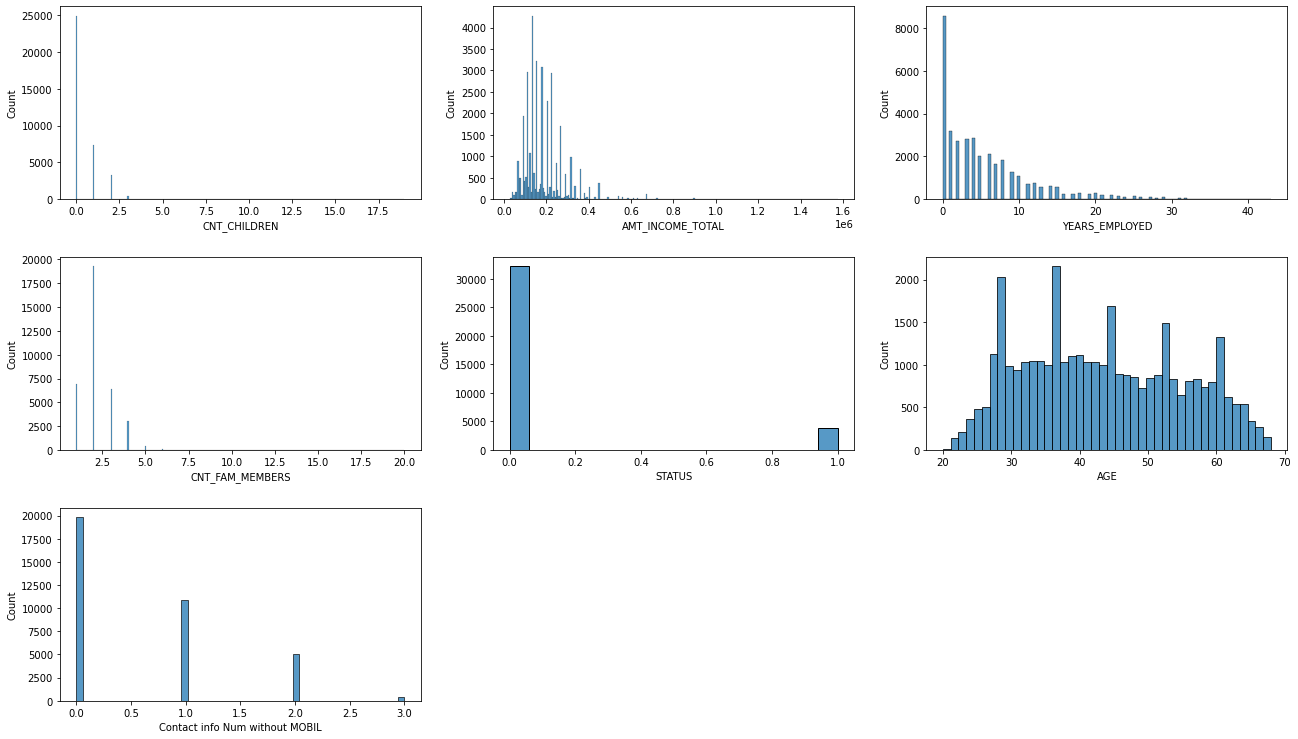

In [19]:
# numeric한 데이터 시각적으로 확인 하기
fig = plt.figure(figsize=(22,22)) 
for i,n in enumerate(numeric_cols_data):
  plt.subplot(5,3,i+1)
  plt.subplots_adjust(hspace = .3)
  sns.histplot(data[n])

In [ ]:
# numeric_cols중 outlier가 있을 것 같은 컬럼은 ['CNT_CHILDREN','AMT_INCOME_TOTAL','AGE','YEARS_EMPLOYED','CNT_FAM_MEMBERS']

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn

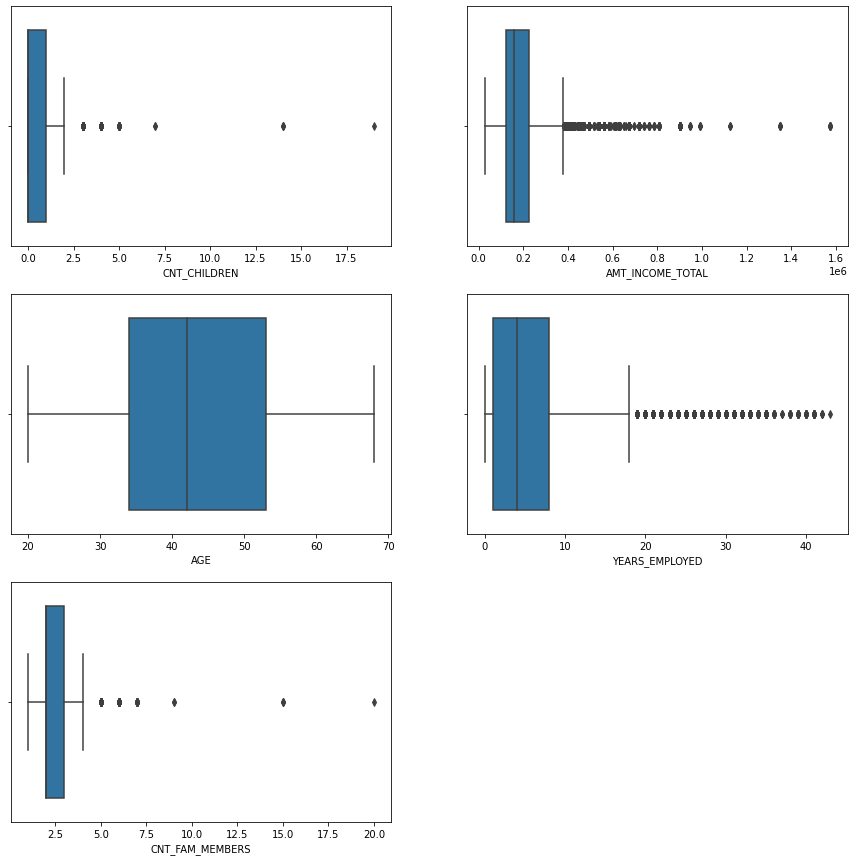

In [20]:
# boxplot으로 Outlier 보기
fig = plt.figure(figsize=(15,15)) 
for i, col in enumerate(['CNT_CHILDREN','AMT_INCOME_TOTAL','AGE','YEARS_EMPLOYED','CNT_FAM_MEMBERS']):
  plt.subplot(3,2,i+1)
  sns.boxplot(data[col])

In [21]:
# outlier 제거하기
# 데이터를 최대한 보전하자 (outlier범위 Max: 0.999, Min:0.001)
def removing_outlier(data):
  for i in ['CNT_CHILDREN','AMT_INCOME_TOTAL','AGE','YEARS_EMPLOYED','CNT_FAM_MEMBERS']:
    data = data[(data[i]>=(data[i].quantile(0.001))) & (data[i]<=(data[i].quantile(0.999)))]
  return data                                                          

In [22]:
removing_outlier(data)

CODE_GENDER FLAG_OWN_CAR  ...   AGE  Contact info Num without MOBIL
0               M            Y  ...  32.0                             1.0
1               M            Y  ...  32.0                             1.0
2               M            Y  ...  58.0                             0.0
3               F            N  ...  52.0                             2.0
4               F            N  ...  52.0                             2.0
...           ...          ...  ...   ...                             ...
36100           F            Y  ...  38.0                             0.0
36101           F            Y  ...  38.0                             0.0
36102           F            N  ...  48.0                             0.0
36103           F            N  ...  48.0                             0.0
36104           F            N  ...  34.0                             0.0

[35949 rows x 14 columns]

Categorical 데이터 살펴보기

In [23]:
for i in data.columns[(data.dtypes=='object').values].tolist():
   print(i,'\n')
   print(data[i].value_counts())
   print('-----------------------------------------------')

CODE_GENDER 

F    24240
M    11865
Name: CODE_GENDER, dtype: int64
-----------------------------------------------
FLAG_OWN_CAR 

N    22384
Y    13721
Name: FLAG_OWN_CAR, dtype: int64
-----------------------------------------------
FLAG_OWN_REALTY 

Y    24309
N    11796
Name: FLAG_OWN_REALTY, dtype: int64
-----------------------------------------------
NAME_INCOME_TYPE 

Working                 18644
Commercial associate     8416
Pensioner                6069
State servant            2965
Student                    11
Name: NAME_INCOME_TYPE, dtype: int64
-----------------------------------------------
NAME_EDUCATION_TYPE 

Secondary / secondary special    24536
Higher education                  9769
Incomplete higher                 1398
Lower secondary                    370
Academic degree                     32
Name: NAME_EDUCATION_TYPE, dtype: int64
-----------------------------------------------
NAME_FAMILY_STATUS 

Married                 24837
Single / not married     4760
Ci

In [24]:
#  Duplicated Value 제거하기
data = data.drop_duplicates()
data.reset_index(drop = True, inplace = True)

In [26]:
data

CODE_GENDER FLAG_OWN_CAR  ...   AGE  Contact info Num without MOBIL
0               M            Y  ...  32.0                             1.0
1               M            Y  ...  58.0                             0.0
2               F            N  ...  52.0                             2.0
3               F            N  ...  61.0                             0.0
4               M            Y  ...  46.0                             3.0
...           ...          ...  ...   ...                             ...
10992           F            N  ...  44.0                             0.0
10993           F            Y  ...  38.0                             0.0
10994           F            Y  ...  38.0                             0.0
10995           F            N  ...  48.0                             0.0
10996           F            N  ...  34.0                             0.0

[10997 rows x 14 columns]

0    0.800764
1    0.199236
Name: STATUS, dtype: float64


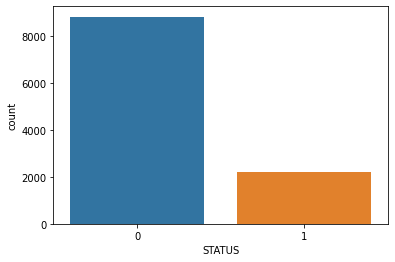

In [27]:
print(data[target].value_counts(normalize = True))
sns.countplot(x=data[target]);
# 이전보다 불균형이 다소 감소 한 것을 볼 수 있다.

In [28]:
major_1 = data[target].mode()[0]
y_pred_1 = [major_1] * len(data[target])

In [29]:
from sklearn.metrics import accuracy_score
print("BaseLine Accuracy:" , accuracy_score(data[target],y_pred_1))

BaseLine Accuracy: 0.800763844684914


In [30]:
col_num = data.columns[(data.dtypes != 'object')]
col_num

Index(['CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'YEARS_EMPLOYED', 'CNT_FAM_MEMBERS',
       'STATUS', 'AGE', 'Contact info Num without MOBIL'],
      dtype='object')

In [31]:
col_ob = data.columns[(data.dtypes == 'object')]
col_ob

Index(['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_INCOME_TYPE',
       'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE'],
      dtype='object')

In [32]:
for i in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_INCOME_TYPE','NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE']:
  print(i,'\n')
  print(data[i].unique())
  print('-----------------------------------------------')

CODE_GENDER 

['M' 'F']
-----------------------------------------------
FLAG_OWN_CAR 

['Y' 'N']
-----------------------------------------------
FLAG_OWN_REALTY 

['Y' 'N']
-----------------------------------------------
NAME_INCOME_TYPE 

['Working' 'Commercial associate' 'Pensioner' 'State servant' 'Student']
-----------------------------------------------
NAME_EDUCATION_TYPE 

['Higher education' 'Secondary / secondary special' 'Incomplete higher'
 'Lower secondary' 'Academic degree']
-----------------------------------------------
NAME_FAMILY_STATUS 

['Civil marriage' 'Married' 'Single / not married' 'Separated' 'Widow']
-----------------------------------------------
NAME_HOUSING_TYPE 

['Rented apartment' 'House / apartment' 'Municipal apartment'
 'With parents' 'Co-op apartment' 'Office apartment']
-----------------------------------------------


- numeric 데이터 StandardScaler 및 밤주형 데이터 encoding

In [33]:
data_num = data[['CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'YEARS_EMPLOYED', 'CNT_FAM_MEMBERS', 'AGE', 'Contact info Num without MOBIL']]
data_categoric = data[['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_INCOME_TYPE','NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE']]

In [34]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler() 
scaler.fit(data_num)
data_num_scaled = scaler.transform(data_num)
data_num_scaled = pd.DataFrame(data_num_scaled).rename(columns = {0:'CNT_CHILDREN',1: 'AMT_INCOME_TOTAL',2:'YEARS_EMPLOYED',3:'CNT_FAM_MEMBERS',4:'AGE',5:'Contact info Num without MOBIL'})

In [35]:
from sklearn.preprocessing import LabelEncoder

cat_columns = data_categoric.columns.tolist()
for col in cat_columns:
  globals()['LE_{}'.format(col)] = LabelEncoder()
  data_categoric[col] = globals()['LE_{}'.format(col)].fit_transform(data_categoric[col])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [36]:
data_result = pd.concat([data_num_scaled,data_categoric],axis=1)

### 4) 머신러닝 방식 적용 및 교차검증 ###

Linear / Tree-based / Ensemble 모델을 학습하세요. (다양하게 시도해보시는 걸 추천합니다.)

평가지표를 계산 후 베이스라인과 비교해보세요.

어느정도 성능이 나왔다면, 교차 검증 (이하 CV)을 통해서 일반화될 가능성이 있는지 확인해봅니다.

모델 성능을 개선하기 위한 다양한 방법을 적용해보세요.

Hyperparameter tuning, etc.
최소 2개 이상의 모델을 만들어서 validation 점수를 보고하세요.

최종 모델의 test 점수를 보고하세요.

모델을 학습한 후에 베이스라인보다 잘 나왔나요? 그렇지 않다면 그 이유는 무엇일까요?
모델 성능 개선을 위해 어떤 방법을 적용했나요? 그 방법을 선택한 이유는 무엇인가요?
최종 모델에 관해 설명하세요.

- 데이터 나누기

In [37]:
target_data = data[[target]]
feature_data = data_result

In [38]:
from sklearn.model_selection import train_test_split

x_train, X_test, Y_train, y_test = train_test_split(feature_data, target_data, test_size=.2, random_state=2)

In [39]:
X_train, X_val, y_train, y_val = train_test_split(x_train, Y_train, test_size=.2, random_state=2)

In [38]:
# train 데이터 X_train, y_train
# validation 데이터 X_val, y_val
# test 데이터 X_test, y_train

- 모델 만들기 학습

Decission Tree

In [40]:
from sklearn.tree import DecisionTreeClassifier

model_DT = DecisionTreeClassifier()
model_DT.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [41]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

print('Decision Tree Model Accuracy : ',model_DT.score(X_test,y_test)*100, '%')

prediction = model_DT.predict(X_test)
print('\nConfusion matrix :')
print(confusion_matrix(y_test, prediction))
      
print('\nClassification report:')      
print(classification_report(y_test, prediction))

Decision Tree Model Accuracy :  60.81818181818181 %

Confusion matrix :
[[1303  441]
 [ 421   35]]

Classification report:
              precision    recall  f1-score   support

           0       0.76      0.75      0.75      1744
           1       0.07      0.08      0.08       456

    accuracy                           0.61      2200
   macro avg       0.41      0.41      0.41      2200
weighted avg       0.61      0.61      0.61      2200



In [42]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, f1_score

y_pred= model_DT.predict(X_val)
f1_score(y_val, y_pred)

0.08389715832205683

In [43]:
from sklearn.ensemble import RandomForestClassifier

model_RF = RandomForestClassifier()
model_RF.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [44]:
y_pred= model_RF.predict(X_val)
f1_score(y_val, y_pred)

0.0038461538461538464

In [45]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

print('Decision Tree Model Accuracy : ',model_RF.score(X_test, y_test)*100, '%')

prediction = model_RF.predict(X_test)
print('\nConfusion matrix :')
print(confusion_matrix(y_test, prediction))
      
print('\nClassification report:')      
print(classification_report(y_test, prediction))

Decision Tree Model Accuracy :  69.13636363636364 %

Confusion matrix :
[[1519  225]
 [ 454    2]]

Classification report:
              precision    recall  f1-score   support

           0       0.77      0.87      0.82      1744
           1       0.01      0.00      0.01       456

    accuracy                           0.69      2200
   macro avg       0.39      0.44      0.41      2200
weighted avg       0.61      0.69      0.65      2200



In [46]:
from xgboost import XGBClassifier

xgb = XGBClassifier()

xgb.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [47]:
y_pred= xgb.predict(X_val)

f1_score(y_val, y_pred)

0.0

In [48]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

print('Decision Tree Model Accuracy : ',xgb.score(X_test, y_test)*100, '%')

prediction = xgb.predict(X_test)
print('\nConfusion matrix :')
print(confusion_matrix(y_test, prediction))
      
print('\nClassification report:')      
print(classification_report(y_test, prediction))

Decision Tree Model Accuracy :  79.27272727272727 %

Confusion matrix :
[[1744    0]
 [ 456    0]]

Classification report:
              precision    recall  f1-score   support

           0       0.79      1.00      0.88      1744
           1       0.00      0.00      0.00       456

    accuracy                           0.79      2200
   macro avg       0.40      0.50      0.44      2200
weighted avg       0.63      0.79      0.70      2200



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


모델들의 성능이 매우 낮은 것을 볼 수 있다.

데이터 밸런싱 하기

In [49]:
import six
import sys
sys.modules['sklearn.externals.six'] = six
import mlrose
from imblearn.over_sampling import SMOTE

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [50]:
oversample = SMOTE(random_state = 42)
feature_data_over, target_data_over = oversample.fit_resample(feature_data,target_data)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [51]:
a = {0:'CNT_CHILDREN',1: 'AMT_INCOME_TOTAL',2:'YEARS_EMPLOYED',3:'CNT_FAM_MEMBERS',4:'AGE',5:'Contact info Num without MOBIL',6:'CODE_GENDER',7:'FLAG_OWN_CAR',8:'FLAG_OWN_REALTY',9:'NAME_INCOME_TYPE',10:'NAME_EDUCATION_TYPE',11:'NAME_FAMILY_STATUS',12:'NAME_HOUSING_TYPE'}
b = {0:'STATUS'}

In [52]:
smotedatatarget = pd.DataFrame(data=feature_data_over).rename(columns = a)
smotedatalabel =pd.DataFrame(target_data_over).rename(columns = b)

STATUS
1         8806
0         8806
dtype: int64


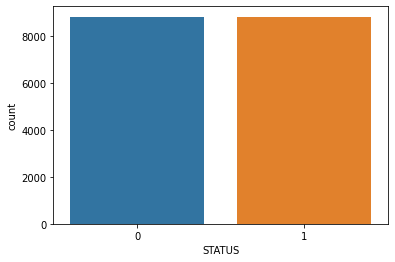

In [53]:
print(smotedatalabel.value_counts())
sns.countplot(x=smotedatalabel[target]);

In [54]:
major_2 = smotedatalabel[target].mode()[0]
y_pred_2 = [major_2]*len(smotedatalabel[target])

In [55]:
from sklearn.metrics import accuracy_score
print("BaseLine Accuracy:" , accuracy_score(smotedatalabel[target],y_pred_2))

BaseLine Accuracy: 0.5


In [56]:
# 데이터 나누기
from sklearn.model_selection import train_test_split

x_train_smote, smotedata_test, Y_train_smote, smotedatalabel_test = train_test_split(smotedatatarget , smotedatalabel, test_size=.2, random_state=2)
smotedata_train, smotedata_val, smotedatalabel_train, smotedatalabel_val = train_test_split(x_train_smote, Y_train_smote, test_size=.2, random_state=2)

In [52]:
"""
oversample = SMOTE(random_state = 42)

X_train_oversample, y_train_oversample = oversample.fit_resample(X_train, y_train)
X_val_oversample, y_val_oversample = oversample.fit_resample(X_val, y_val)
X_test_oversample, y_test_oversample = oversample.fit_resample(X_test, y_test)

smotedata_train = pd.DataFrame(data=X_train_oversample).rename(columns = a)
smotedatalabel_train =pd.DataFrame(y_train_oversample).rename(columns = b)

smotedata_val = pd.DataFrame(data=X_val_oversample).rename(columns = a)
smotedatalabel_val =pd.DataFrame(y_val_oversample).rename(columns = b)

smotedata_test = pd.DataFrame(data=X_test_oversample).rename(columns = a)
smotedatalabel_test =pd.DataFrame(y_test_oversample).rename(columns = b)
"""

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, 

데이터 밸런싱 후 모델 학습

In [57]:
model_DT.fit(smotedata_train, smotedatalabel_train)
y_pred_DT= model_DT.predict(smotedata_test)
f1_score(smotedatalabel_test, y_pred_DT)

0.7250211089220376

In [58]:
model_RF.fit(smotedata_train, smotedatalabel_train)
y_pred_RF= model_RF.predict(smotedata_test)
f1_score(smotedatalabel_test, y_pred_RF)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


0.7563466588853225

In [59]:
xgb.fit(smotedata_train, smotedatalabel_train)
y_pred_xgb= xgb.predict(smotedata_test)
f1_score(smotedatalabel_test, y_pred_xgb)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.7883713660518912

- 적합한 하이퍼 파라미터 찾기

Decision Tree

In [77]:
from sklearn.model_selection import GridSearchCV

dt = DecisionTreeClassifier()
param_grid = {
    'max_depth':[4,5,6,7],
    'max_leaf_nodes':[3,5,7,9,10],
    'criterion':['entropy'] #기본값 말고 다른값을 사용할 경우.
}

gs = GridSearchCV(dt, 
                  param_grid=param_grid,
                  scoring='accuracy',
                  cv = 3,
                  n_jobs=-1)
gs.fit(smotedata_train, smotedatalabel_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=-1,
             param_grid={'criterion': ['entropy'], 'max_depth': [4, 5, 6, 7],
  

In [78]:
print('최적 하이퍼 파라미터:\n', gs.best_params_)
print('최고 예측 정확도: {0:.4f}'.format(gs.best_score_))

최적 하이퍼 파라미터:
 {'criterion': 'entropy', 'max_depth': 5, 'max_leaf_nodes': 10}
최고 예측 정확도: 0.6629


In [60]:
model_DT = DecisionTreeClassifier(criterion= 'entropy', max_depth= 5, max_leaf_nodes=10)
model_DT.fit(smotedata_train, smotedatalabel_train)

y_pred_DT= model_DT.predict(smotedata_test)

f1_score(smotedatalabel_test, y_pred_DT)

0.5522727272727272

In [81]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

print('Decision Tree Model Accuracy : ',model_DT.score(smotedata_test, smotedatalabel_test)*100, '%')

prediction = model_DT.predict(smotedata_test)
print('\nConfusion matrix :')
print(confusion_matrix(smotedatalabel_test, prediction))
      
print('\nClassification report:')      
print(classification_report(smotedatalabel_test, prediction))

Decision Tree Model Accuracy :  66.44904910587567 %

Confusion matrix :
[[1612  100]
 [1082  729]]

Classification report:
              precision    recall  f1-score   support

           0       0.60      0.94      0.73      1712
           1       0.88      0.40      0.55      1811

    accuracy                           0.66      3523
   macro avg       0.74      0.67      0.64      3523
weighted avg       0.74      0.66      0.64      3523



In [73]:
y_pred_proba_DT = model_DT.predict(smotedata_val)

Random Forest

In [83]:
from sklearn.model_selection import GridSearchCV

params = {
    'n_estimators':[200,250,300],
    'max_depth' : [8, 10,12,14], 
    'min_samples_leaf' : [8, 12, 18],
    'min_samples_split' : [8, 16, 20,24]
}
# RandomForestClassifier 객체 생성 후 GridSearchCV 수행
rf_clf = RandomForestClassifier(random_state=42, n_jobs=-1)
grid_cv_0 = GridSearchCV(rf_clf, param_grid=params, cv=2, n_jobs=-1)
grid_cv_0.fit(smotedata_train, smotedatalabel_train)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:739: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


GridSearchCV(cv=2, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=-1,
                                              oob_score=False, random_state=42,
                                    

In [ ]:
print('최적 하이퍼 파라미터:\n', grid_cv_0.best_params_)
print('최고 예측 정확도: {0:.4f}'.format(grid_cv_0.best_score_))

In [63]:
model_RF = RandomForestClassifier(random_state=42, n_jobs=-1,max_depth= 14, min_samples_leaf= 8, min_samples_split= 8, n_estimators= 250)
model_RF.fit(smotedata_train, smotedatalabel_train)

y_pred_RF= model_RF.predict(smotedata_test)

f1_score(smotedatalabel_test, y_pred_RF)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


0.7568777991042868

In [86]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

print('Random Forest Model Accuracy : ',model_RF.score(smotedata_test, smotedatalabel_test)*100, '%')

prediction = model_RF.predict(smotedata_test)
print('\nConfusion matrix :')
print(confusion_matrix(smotedatalabel_test, prediction))
      
print('\nClassification report:')      
print(classification_report(smotedatalabel_test, prediction))

Random Forest Model Accuracy :  78.42747658245813 %

Confusion matrix :
[[1580  132]
 [ 628 1183]]

Classification report:
              precision    recall  f1-score   support

           0       0.72      0.92      0.81      1712
           1       0.90      0.65      0.76      1811

    accuracy                           0.78      3523
   macro avg       0.81      0.79      0.78      3523
weighted avg       0.81      0.78      0.78      3523



In [64]:
y_pred_proba_RF = model_RF.predict(smotedata_val)

XGBoost

In [95]:
params = {
    'n_estimators':[340,360,380],
    'xgbclassifier__colsample_bytree': [0.1,0.2,0.3,0.4,],
    'xgbclassifier__reg_alpha': [0.5,0.6,0.7,0.9],
    'xgbclassifier__reg_lambda': [0.5,0.6,0.7,0.9]
}
# RandomForestClassifier 객체 생성 후 GridSearchCV 수행

grid_xgb = GridSearchCV(xgb, param_grid=params, cv=2, n_jobs=-1)
grid_xgb.fit(smotedata_train, smotedatalabel_train)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GridSearchCV(cv=2, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=360, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_po...
                                     xgbclassifier__reg_lambda=0.7),
             iid='deprecated', n_jobs=-1,
             param_grid={'n_estimators': [340, 360, 380],
                         'xgbclassifier__colsample_bytree': [0.1, 0.2, 0.3,
                                                             0.4],
     

In [96]:
print('최적 하이퍼 파라미터:\n', grid_xgb.best_params_)
print('최고 예측 정확도: {0:.4f}'.format(grid_xgb.best_score_))

최적 하이퍼 파라미터:
 {'n_estimators': 380, 'xgbclassifier__colsample_bytree': 0.1, 'xgbclassifier__max_depth': 2, 'xgbclassifier__reg_alpha': 0.5, 'xgbclassifier__reg_lambda': 0.5}
최고 예측 정확도: 0.8425


In [91]:
xgb = XGBClassifier(n_estimators= 380, xgbclassifier__colsample_bytree= 0.1, xgbclassifier__max_depth= 6, xgbclassifier__reg_alpha= 0.5, xgbclassifier__reg_lambda= 0.5)

xgb.fit(smotedata_train, smotedatalabel_train)

y_pred= xgb.predict(smotedata_test)

f1_score(smotedatalabel_test, y_pred)

0.8323881537492124

In [92]:
print('XGBoost Model Accuracy : ',xgb.score(smotedata_test, smotedatalabel_test)*100, '%')

prediction =xgb.predict(smotedata_test)
print('\nConfusion matrix :')
print(confusion_matrix(smotedatalabel_test, prediction))
      
print('\nClassification report:')      
print(classification_report(smotedatalabel_test, prediction))

XGBoost Model Accuracy :  84.89923360772069 %

Confusion matrix :
[[1670   42]
 [ 490 1321]]

Classification report:
              precision    recall  f1-score   support

           0       0.77      0.98      0.86      1712
           1       0.97      0.73      0.83      1811

    accuracy                           0.85      3523
   macro avg       0.87      0.85      0.85      3523
weighted avg       0.87      0.85      0.85      3523



In [93]:
y_pred_proba_xgb = xgb.predict(smotedata_val)

XGBoost가 가장 높은 성능을 보여주는 모델임을 알 수 있다.

- 교차검증

In [68]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
kfold = KFold(5)

In [69]:
results=cross_val_score(model_DT,feature_data ,target_data,cv=kfold)
print(results*100,'\n')

print(np.mean(results)*100)

[80.36363636 81.31818182 78.3992724  81.08231014 79.12687585] 

80.05805531439911


In [70]:
results=cross_val_score(model_RF,feature_data ,target_data,cv=kfold)
print(results*100,'\n')

print(np.mean(results)*100)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 

[80.31818182 81.27272727 78.53569804 81.08231014 79.17235107] 

80.0762536690231


In [71]:
results=cross_val_score(xgb,feature_data ,target_data,cv=kfold)
print(results*100,'\n')

print(np.mean(results)*100)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[80.31818182 81.22727273 78.3992724  81.03683492 79.17235107] 

80.03078258712637


세 개의 모델 비교

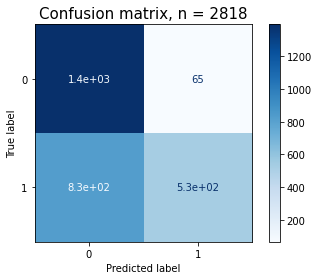

              precision    recall  f1-score   support

           0       0.63      0.96      0.76      1461
           1       0.89      0.39      0.54      1357

    accuracy                           0.68      2818
   macro avg       0.76      0.67      0.65      2818
weighted avg       0.75      0.68      0.65      2818



In [74]:
from sklearn.metrics import plot_confusion_matrix

fig, ax = plt.subplots()
pcm = plot_confusion_matrix(model_DT, smotedata_val, smotedatalabel_val,
                            cmap=plt.cm.Blues,
                            ax=ax);
plt.title(f'Confusion matrix, n = {len(smotedatalabel_val)}', fontsize=15)
plt.show()
print(classification_report(smotedatalabel_val, y_pred_proba_DT))

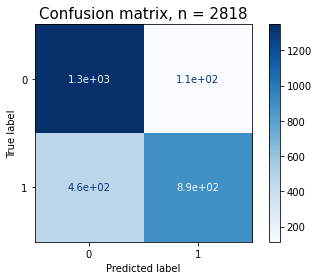

              precision    recall  f1-score   support

           0       0.74      0.92      0.82      1461
           1       0.89      0.66      0.76      1357

    accuracy                           0.79      2818
   macro avg       0.82      0.79      0.79      2818
weighted avg       0.81      0.79      0.79      2818



In [75]:
from sklearn.metrics import plot_confusion_matrix

fig, ax = plt.subplots()
pcm = plot_confusion_matrix(model_RF, smotedata_val, smotedatalabel_val,
                            cmap=plt.cm.Blues,
                            ax=ax);
plt.title(f'Confusion matrix, n = {len(smotedatalabel_val)}', fontsize=15)
plt.show()
print(classification_report(smotedatalabel_val, y_pred_proba_RF))

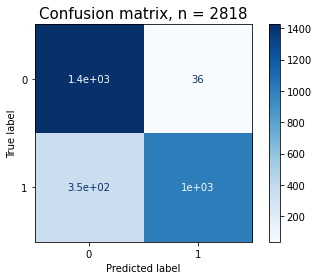

              precision    recall  f1-score   support

           0       0.80      0.98      0.88      1461
           1       0.97      0.74      0.84      1357

    accuracy                           0.86      2818
   macro avg       0.88      0.86      0.86      2818
weighted avg       0.88      0.86      0.86      2818



In [94]:
from sklearn.metrics import plot_confusion_matrix

fig, ax = plt.subplots()
pcm = plot_confusion_matrix(xgb, smotedata_val, smotedatalabel_val,
                            cmap=plt.cm.Blues,
                            ax=ax);
plt.title(f'Confusion matrix, n = {len(smotedatalabel_val)}', fontsize=15)
plt.show()
print(classification_report(smotedatalabel_val, y_pred_proba_xgb))

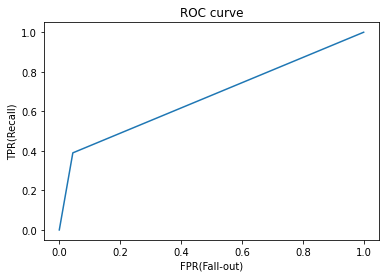

0.6726702165918399


In [95]:
# ROC curve와 AUC 점수
from sklearn.metrics import roc_auc_score, roc_curve

auc_score_model = roc_auc_score(smotedatalabel_val, y_pred_proba_DT)

fpr_1, tpr_1, thresholds_1 = roc_curve(smotedatalabel_val,  y_pred_proba_DT)

roc_1 = pd.DataFrame({'FPR(Fall-out)': fpr_1, 
                        'TPRate(Recall)': tpr_1, 
                        'Threshold': thresholds_1})

plt.plot(fpr_1, tpr_1) 
plt.title('ROC curve')
plt.xlabel('FPR(Fall-out)')
plt.ylabel('TPR(Recall)')
plt.show()
print(auc_score_model)

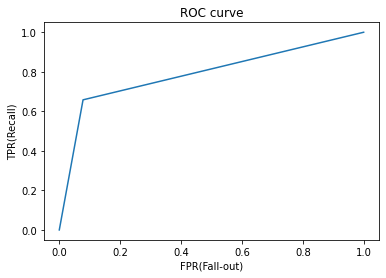

0.790020261508128


In [79]:
# ROC curve와 AUC 점수

auc_score_model = roc_auc_score(smotedatalabel_val, y_pred_proba_RF)

fpr_1, tpr_1, thresholds_1 = roc_curve(smotedatalabel_val,  y_pred_proba_RF)

roc_1 = pd.DataFrame({'FPR(Fall-out)': fpr_1, 
                        'TPRate(Recall)': tpr_1, 
                        'Threshold': thresholds_1})

plt.plot(fpr_1, tpr_1) 
plt.title('ROC curve')
plt.xlabel('FPR(Fall-out)')
plt.ylabel('TPR(Recall)')
plt.show()
print(auc_score_model)

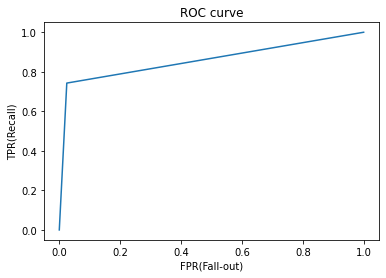

0.8590871880385983


In [96]:
auc_score_xgb = roc_auc_score(smotedatalabel_val, y_pred_proba_xgb)

fpr_1, tpr_1, thresholds_1 = roc_curve(smotedatalabel_val,  y_pred_proba_xgb)

roc_1 = pd.DataFrame({'FPR(Fall-out)': fpr_1, 
                        'TPRate(Recall)': tpr_1, 
                        'Threshold': thresholds_1})

plt.plot(fpr_1, tpr_1) 
plt.title('ROC curve')
plt.xlabel('FPR(Fall-out)')
plt.ylabel('TPR(Recall)')
plt.show()
print(auc_score_xgb)

### xgboost가 가장 우수한 모델이다.### 

### 머신러닝 모델 해석 ###
- PDP, SHAP을 활용하여 최종 모델을 설명합니다
- 가장 우수한 XGBoost를 활용한 모델을 해석 할 것이다.

- 1. 모델이 관측치를 예측하기 위해서 어떤 특성을 활용했나요?
- 2. 어떤 특성이 있다면 모델의 예측에 도움이 될까요? 해당 특성은 어떻게 구할 수 있을까요?

PDP

In [97]:
from pdpbox.pdp import pdp_isolate, pdp_plot

In [98]:
feature_list_num = ['CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'YEARS_EMPLOYED', 'CNT_FAM_MEMBERS',
       'AGE', 'Contact info Num without MOBIL'] 

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


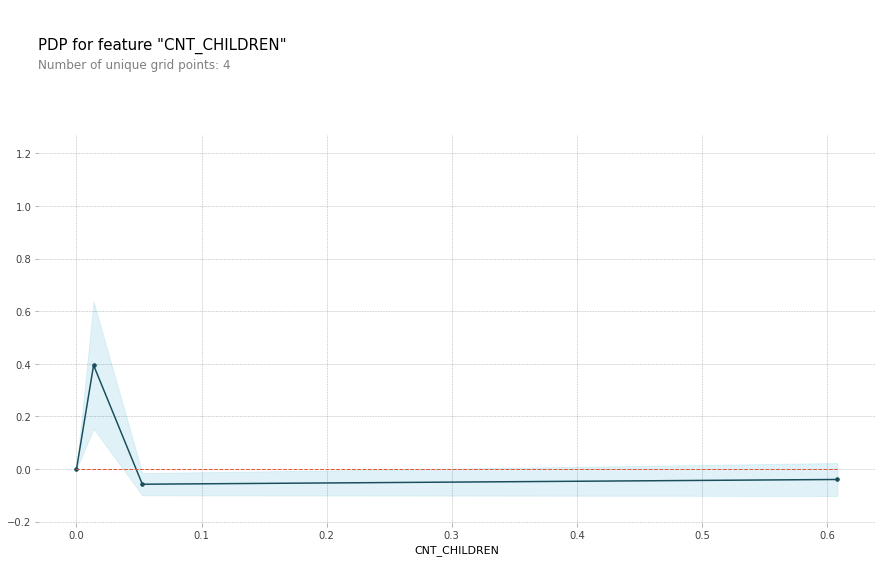

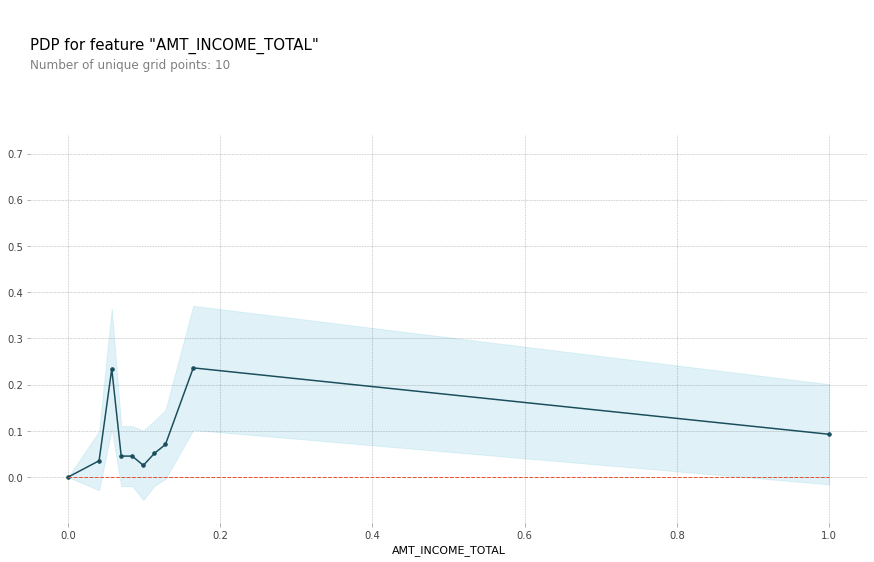

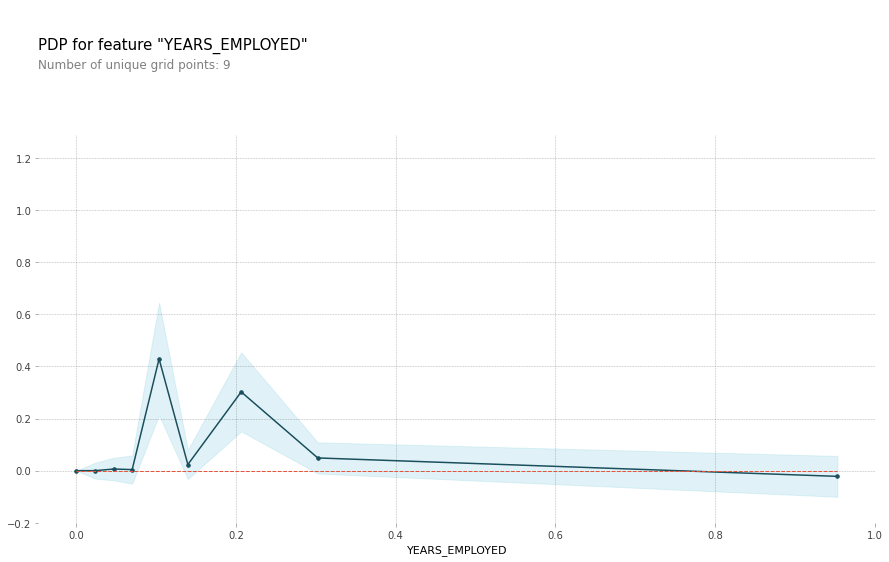

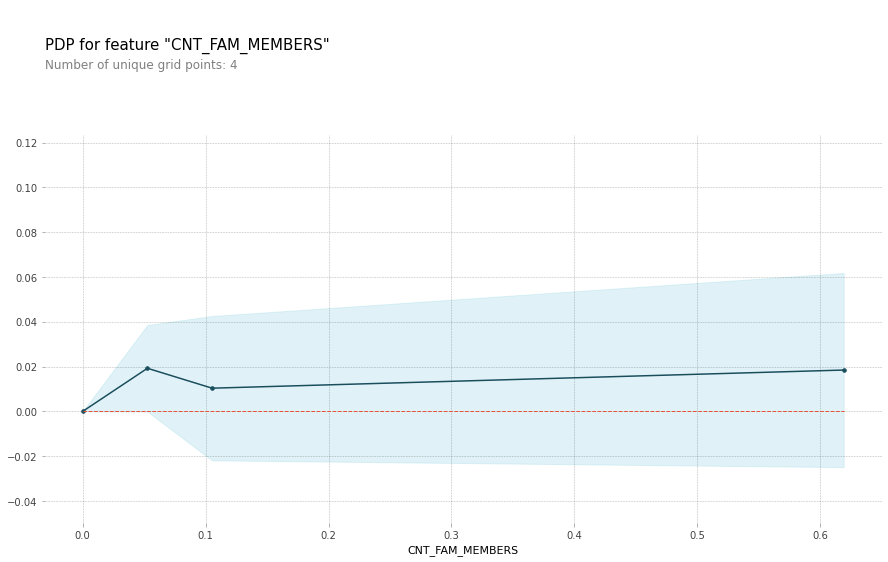

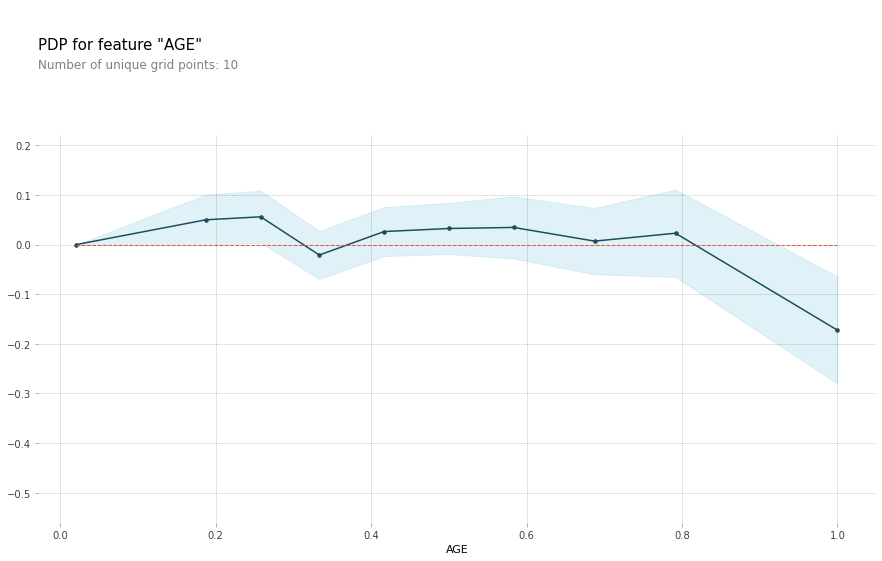

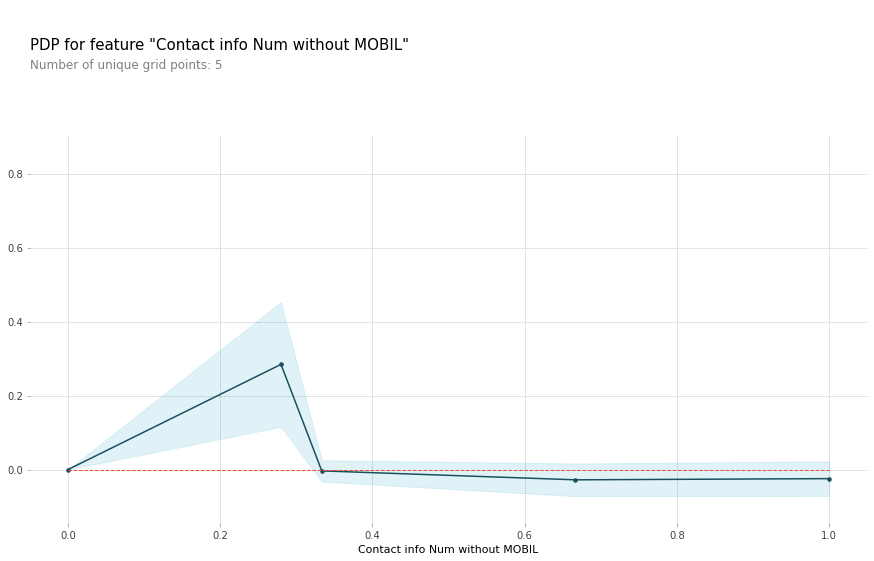

In [99]:
for i in feature_list_num:
  isolated = pdp_isolate(
      xgb, 
      dataset=smotedata_test, 
      model_features=smotedata_test.columns, 
      feature=i
  )
  pdp_plot(isolated, feature_name=i);

In [100]:
feature_list_cat = ['CODE_GENDER', 'FLAG_OWN_CAR',
       'FLAG_OWN_REALTY', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE']

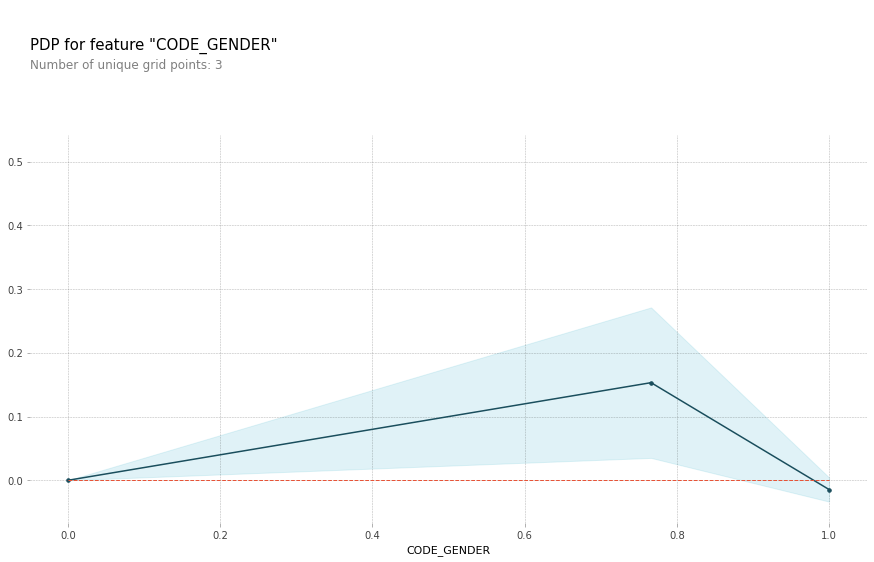

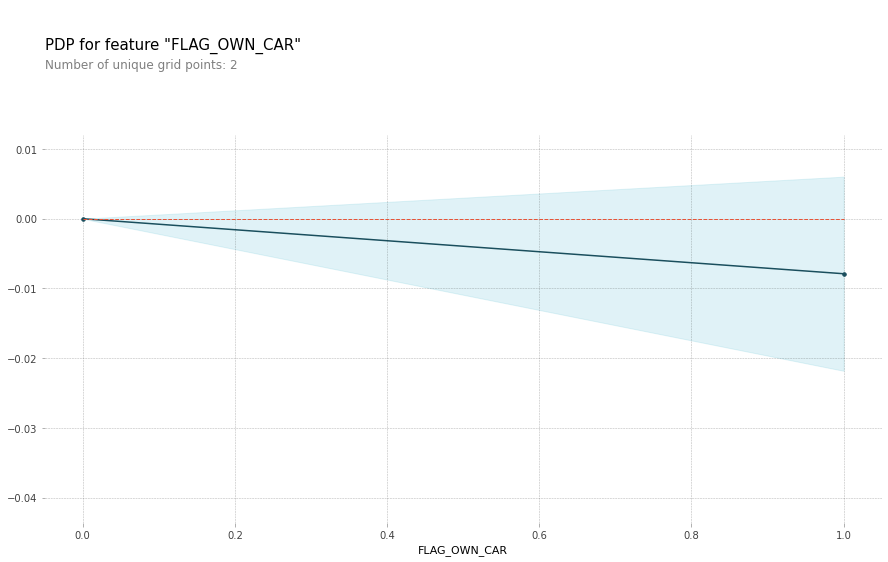

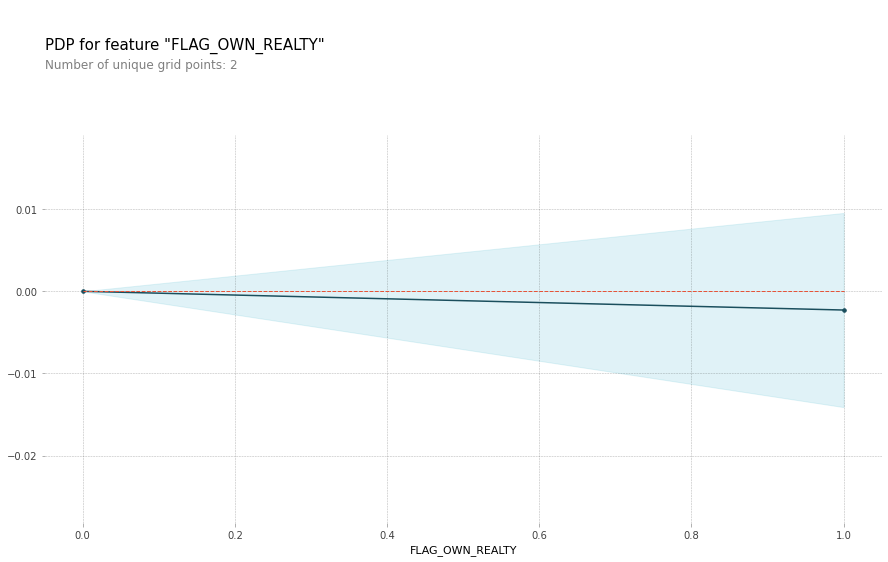

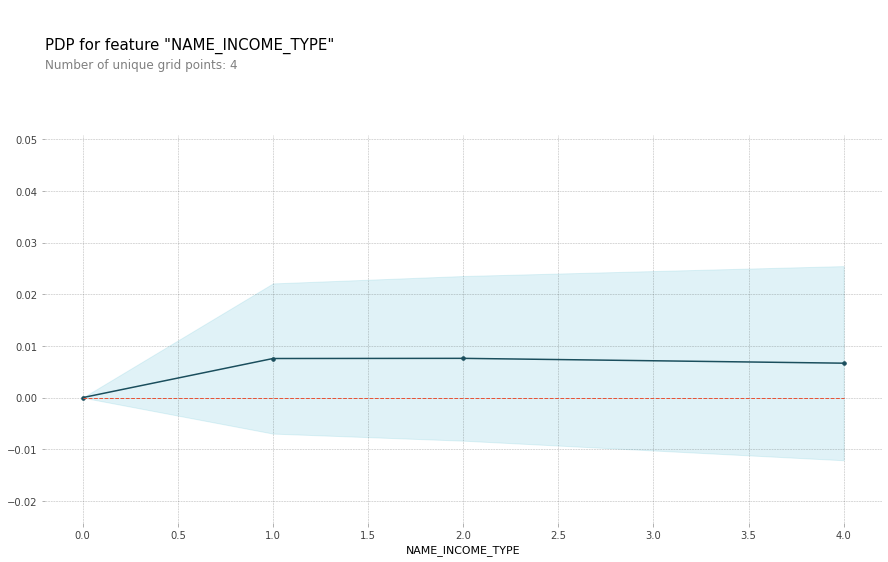

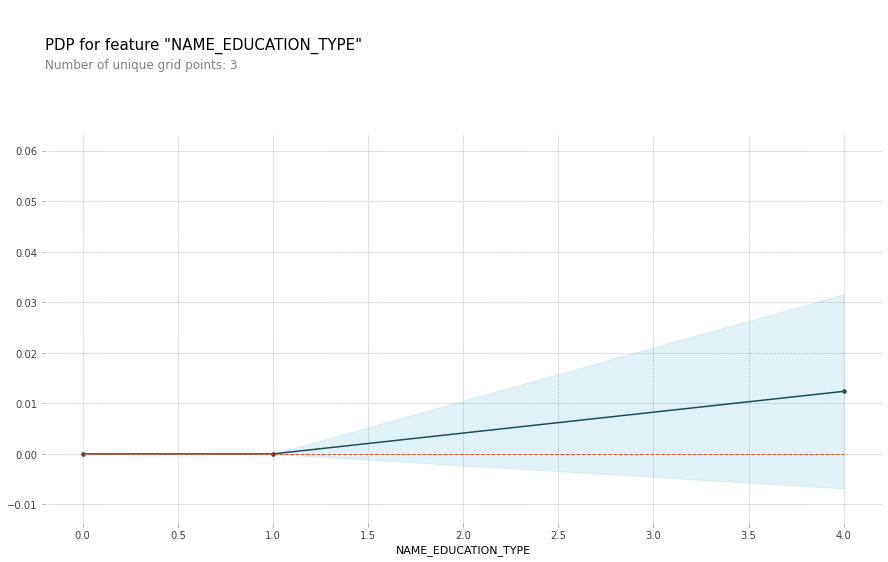

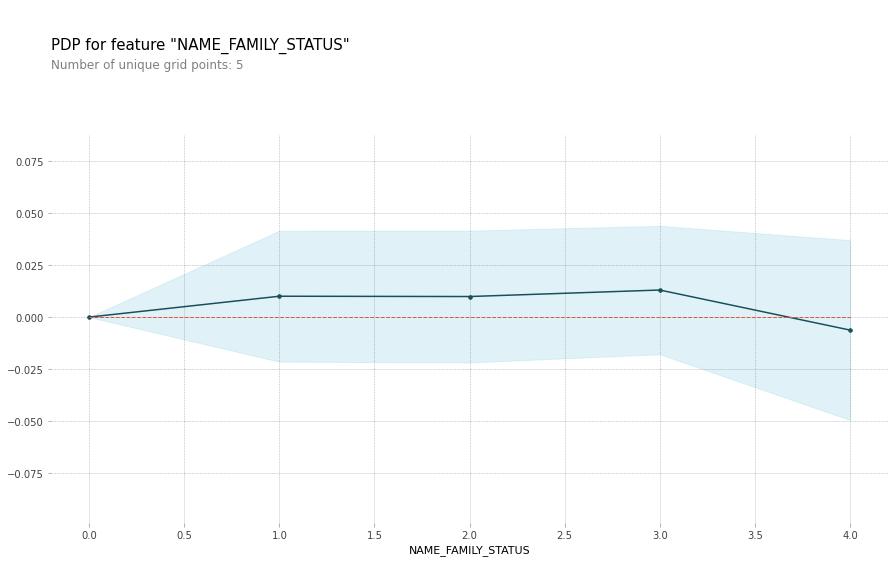

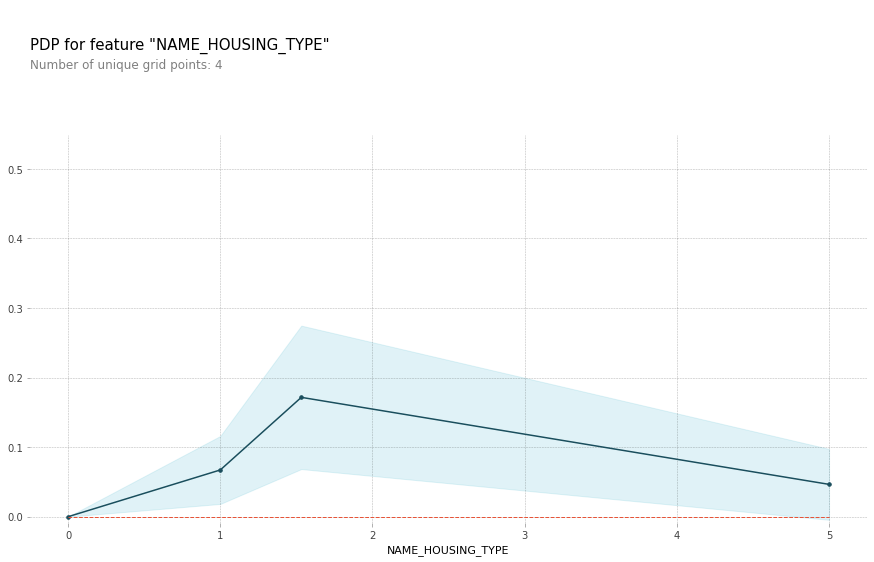

In [101]:
for i in feature_list_cat:
  isolated = pdp_isolate(
      xgb, 
      dataset=smotedata_test, 
      model_features=smotedata_test.columns, 
      feature=i
  )
  pdp_plot(isolated, feature_name=i);

해석 : 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE'은 target을 예측하는덷 양의 영향을 미칩니다. 'FLAG_OWN_REALTY'은 음의 영향을 미칩니다.


SHAP

In [102]:
import shap

In [104]:
explainer = shap.TreeExplainer(xgb)
row_col = smotedata_test.iloc[[1]]
shap_values = explainer.shap_values(row_col)

shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value, 
    shap_values=shap_values,
    features=row_col)

In [105]:
row = smotedata_test.iloc[:100]

explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(row)

shap.initjs()
shap.force_plot(
    base_value = explainer.expected_value,
    shap_values = shap_values,
    features = row
)

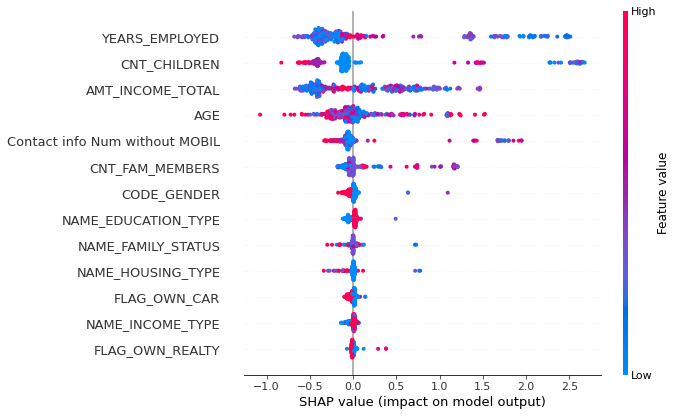

In [106]:
shap_values = explainer.shap_values(smotedata_test.iloc[:300])
shap.summary_plot(shap_values, smotedata_test.iloc[:300])

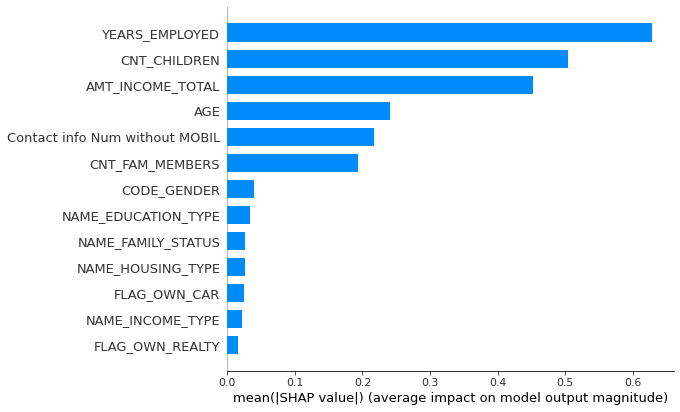

In [107]:
shap.summary_plot(shap_values, smotedata_test, plot_type='bar')

In [108]:
pd.Series(xgb.feature_importances_, smotedata_test.columns).sort_values(ascending = False)

CNT_CHILDREN                      0.369782
Contact info Num without MOBIL    0.130634
YEARS_EMPLOYED                    0.103854
CNT_FAM_MEMBERS                   0.083447
AMT_INCOME_TOTAL                  0.078743
CODE_GENDER                       0.074710
AGE                               0.039434
NAME_HOUSING_TYPE                 0.024992
FLAG_OWN_REALTY                   0.021573
FLAG_OWN_CAR                      0.020818
NAME_INCOME_TYPE                  0.018182
NAME_EDUCATION_TYPE               0.017131
NAME_FAMILY_STATUS                0.016701
dtype: float32

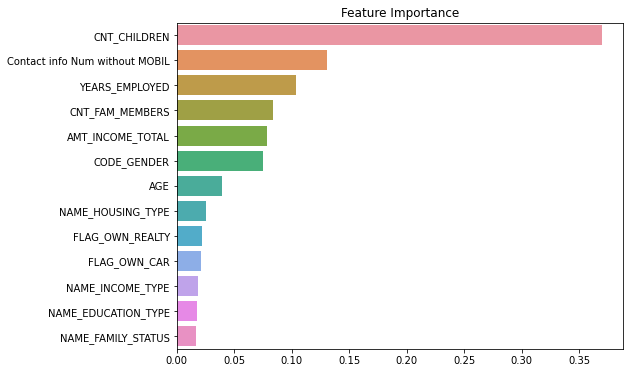

In [168]:
ft_series = pd.Series(xgb.feature_importances_, smotedata_test.columns).sort_values(ascending = False)
feature_importance = ft_series.sort_values(ascending=False)

plt.figure(figsize=(8,6))
plt.title('Feature Importance')
sns.barplot(x=feature_importance , y=feature_importance .index)
plt.show()